<h1 align='center'>Deteccion de anomalías en grandes volúmenes de datos</h1>


## Análisis del dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import itertools
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
from timeit import default_timer as timer

In [2]:
df = pd.read_csv('input/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Ahora determinamos la cantidad de transacciones fraudulentas en el dataset.

In [4]:
frauds = (df['Class'] == 1)

In [5]:
len(df[frauds])

492

In [6]:
len(df)

284807

Lo anterior nos indica que de las $284,807$ transacciones en el dataset, $492$ corresponden a transacciones fraudulentas, de modo que el resto de transacciones, $284,315$, son transacciones normales. Podemos visualizar esto en un gráfico de pastel.

<AxesSubplot:>

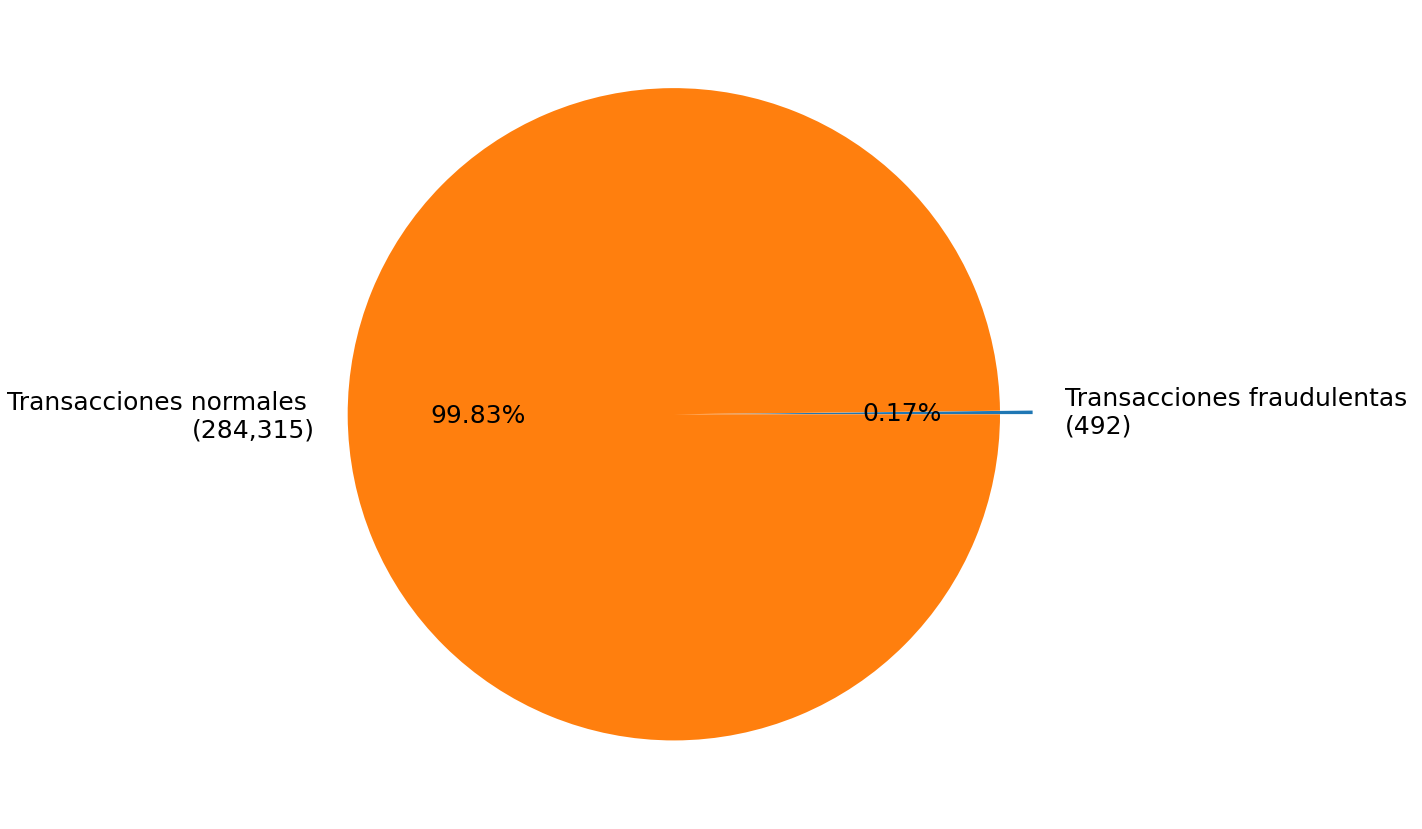

In [7]:
plot_data = pd.DataFrame({ 'Tipo de transacción': ['Transacciones fraudulentas \n(492)', 'Transacciones normales \n(284,315)'],
                  'Cantidad': [492, 284315]})

plot_data.set_index('Tipo de transacción', inplace=True)
plot = plot_data.plot.pie(y='Cantidad', legend=False, \
                   autopct='%1.2f%%', explode=(0, 0.1), \
                   shadow=False, startangle=0, figsize=(15, 15), fontsize=25);
pylab.ylabel('')
plot

Podemos verificar que en este dataset no hay datos nulos:

In [8]:
df.isnull().values.any()

False

In [9]:
df.isnull().sum().sum()

0

## Matriz de correlación

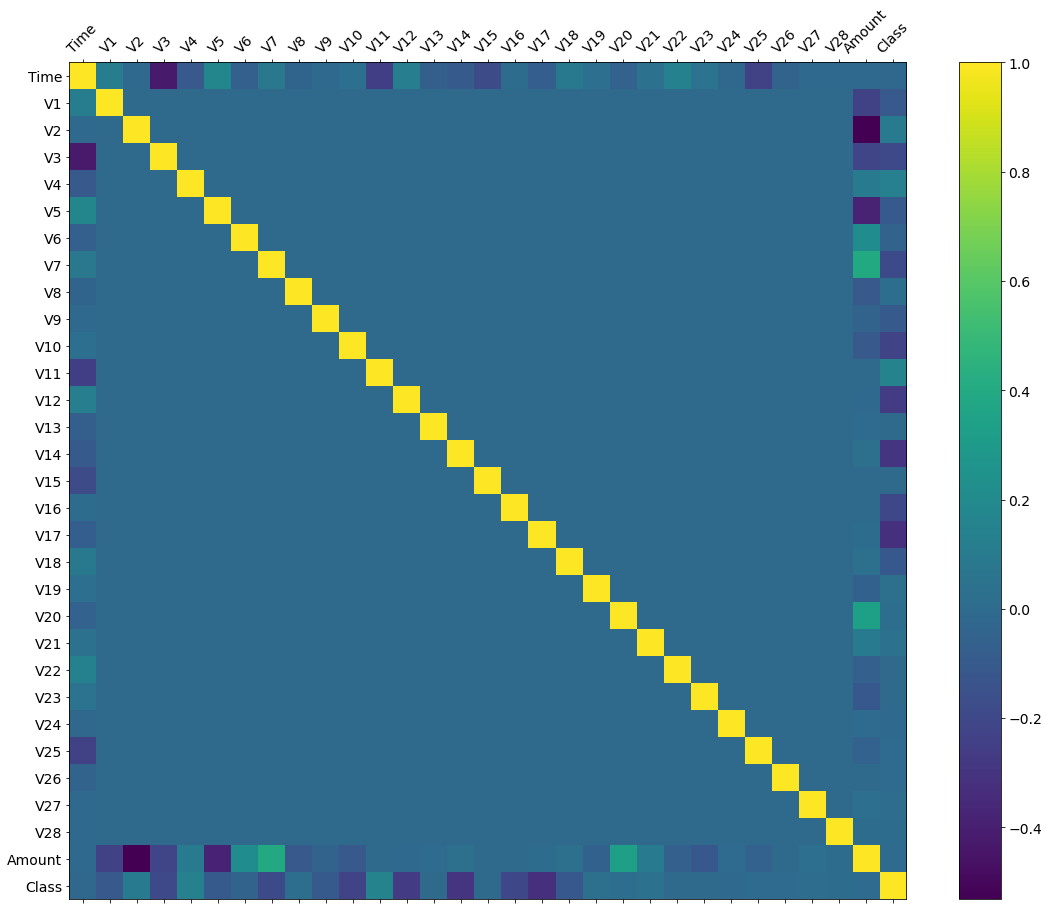

In [10]:
f = plt.figure(figsize=(19, 15))
corrMatrix = df.corr()
plt.matshow(corrMatrix, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

## Preprocesamiento

### Separando en conjuntos de entrenamiento y de prueba

In [11]:
X = df.drop('Class', axis=1)
y = df['Class']

# Generando conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

### Escalando columnas

In [12]:
robust_scaler = RobustScaler()

## training set

scaled_train_amount = robust_scaler.fit_transform(train_data['Amount'].values.reshape(-1,1))
scaled_train_time = robust_scaler.fit_transform(train_data['Time'].values.reshape(-1,1))

train_data.drop(['Amount', 'Time'], axis=1, inplace=True)
train_data.insert(0, 'scaled_amount', scaled_train_amount)
train_data.insert(1, 'scaled_time', scaled_train_time)

train_data.head()

#test set

scaled_test_amount = robust_scaler.fit_transform(test_data['Amount'].values.reshape(-1,1))
scaled_test_time = robust_scaler.fit_transform(test_data['Time'].values.reshape(-1,1))

test_data.drop(['Amount', 'Time'], axis=1, inplace=True)
test_data.insert(0, 'scaled_amount', scaled_test_amount)
test_data.insert(1, 'scaled_time', scaled_test_time)

test_data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
43428,4.789223,-0.510245,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,...,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,1
49906,6.971589,-0.477893,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,0
29474,0.125962,-0.580925,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,0
276481,-0.286914,0.964378,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,0
278846,-0.295451,0.980226,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0


### Implementando random undersampling

In [13]:
train_frauds = train_data[train_data.Class == 1]
train_non_frauds = train_data[train_data.Class == 0]

# Extracting the same amount of non frauds as frauds from training set 
downsampled = resample(train_non_frauds, replace=True, n_samples=len(train_frauds), random_state=27)

train_undersampled = pd.concat([train_frauds, downsampled])

# Print  
[undersampled_non_frauds, undersampled_frauds] = train_undersampled.Class.value_counts()
print("Undersample non frauds count:", undersampled_non_frauds)
print("Undersample frauds count:", undersampled_frauds)

Undersample non frauds count: 343
Undersample frauds count: 343


In [14]:
train_undersampled.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
42958,-0.167410,-0.508543,-13.897206,6.344280,-14.281666,5.581009,-12.887133,-3.146176,-15.450467,9.060281,...,-1.025228,3.058082,0.941180,-0.232710,0.763508,0.075456,-0.453840,-1.508968,-0.686836,1
10484,-0.253833,-0.792038,1.088375,0.898474,0.394684,3.170258,0.175739,-0.221981,-0.022989,-0.010874,...,-0.217358,-0.423554,-0.800852,0.077614,0.167608,0.350182,-0.118941,0.012948,0.054254,1
69980,-0.306663,-0.363481,-1.739341,1.344521,-0.534379,3.195291,-0.416196,-1.261961,-2.340991,0.713004,...,0.002749,0.383180,-0.213952,-0.336640,0.237076,0.246003,-0.044228,0.510729,0.220952,1
10801,-0.292724,-0.777796,-14.474437,6.503185,-17.712632,11.270352,-4.150142,-3.372098,-16.535807,-1.443947,...,1.101250,-2.475962,0.342391,-3.564508,-0.818140,0.153408,0.755079,2.706566,-0.992916,1
107637,11.190828,-0.165155,-2.271755,-0.457655,-2.589055,2.230778,-4.278983,0.388610,0.102485,0.813128,...,2.285758,1.096342,0.658399,1.711676,0.333540,0.538591,-0.193529,0.258194,0.247269,1


<AxesSubplot:>

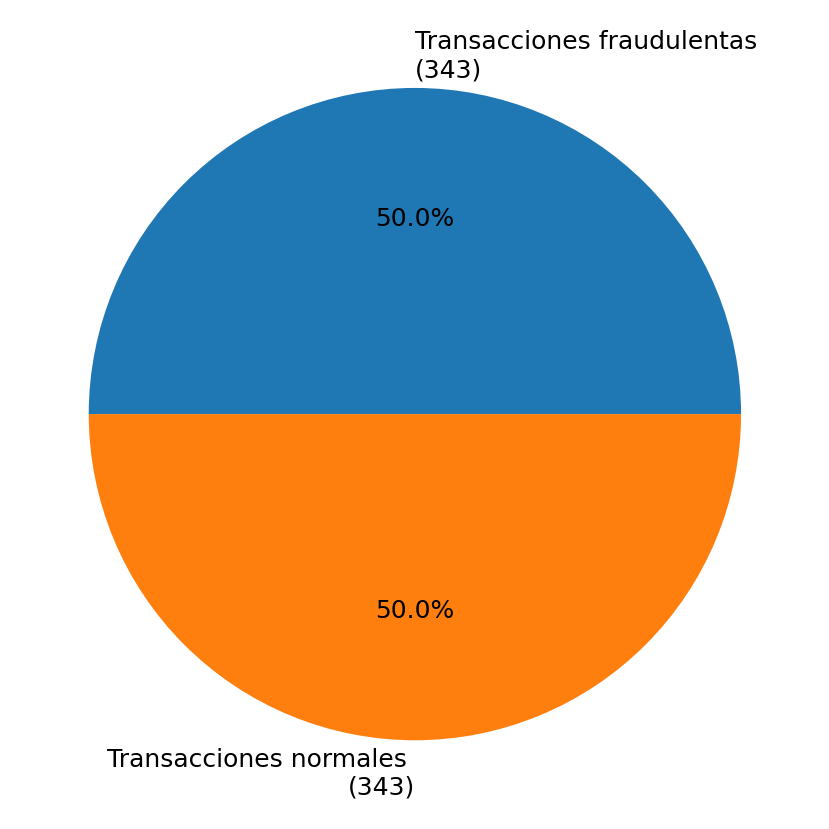

In [15]:
plot_data = pd.DataFrame({ 'Tipo de transacción': [
    'Transacciones fraudulentas \n({})'.format(undersampled_frauds),
    'Transacciones normales \n({})'.format(undersampled_non_frauds)
],
                          'Cantidad': [undersampled_frauds, undersampled_non_frauds]})

plot_data.set_index('Tipo de transacción', inplace=True)
plot = plot_data.plot.pie(y='Cantidad', legend=False, \
                   autopct='%1.1f%%', \
                   shadow=False, startangle=0, figsize=(15, 15), fontsize=25);
pylab.ylabel('')
plot

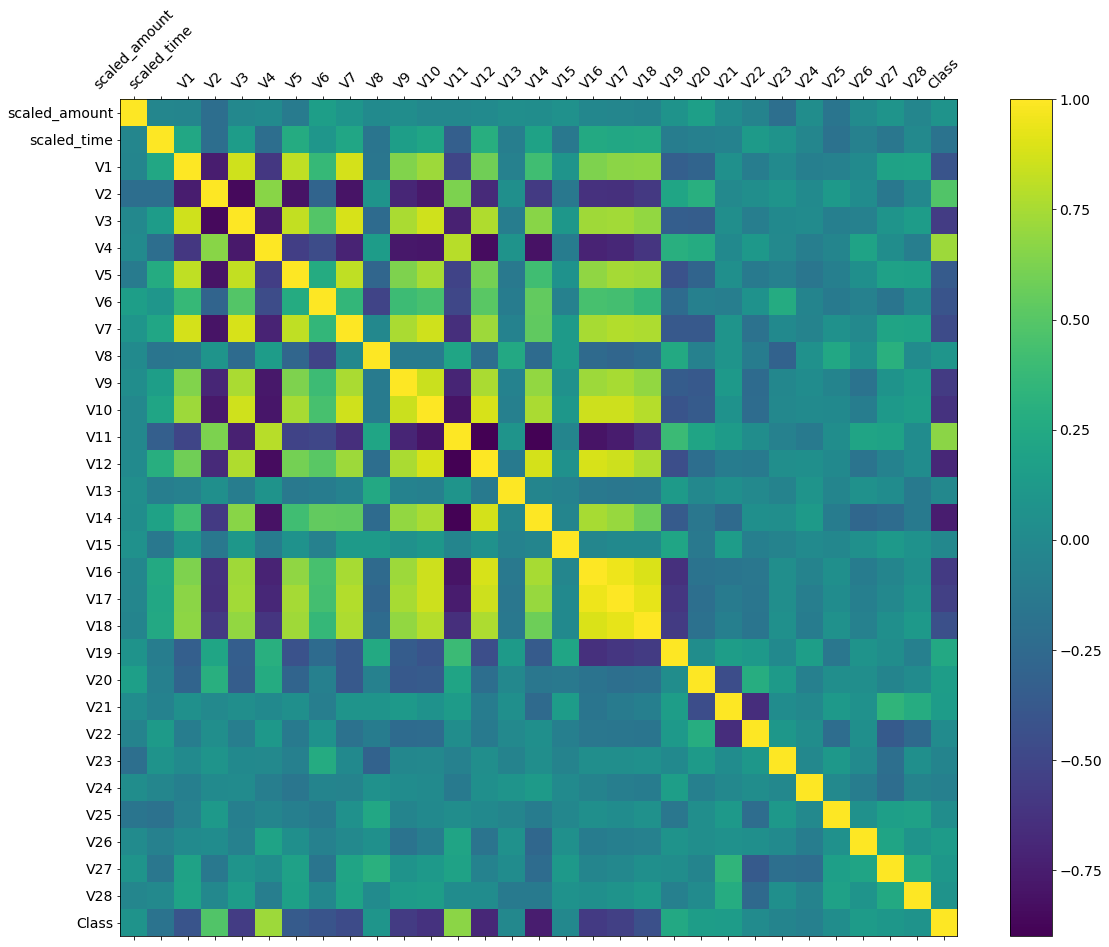

In [16]:
f = plt.figure(figsize=(19, 15))
corrMatrix = train_undersampled.corr()
plt.matshow(corrMatrix, fignum=f.number)
plt.xticks(range(train_undersampled.select_dtypes(['number']).shape[1]), train_undersampled.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train_undersampled.select_dtypes(['number']).shape[1]), train_undersampled.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

## Implementación de clasificadores

### Función para imprimir matriz de confusión

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión',
                          cmap=plt.cm.Reds):
    
    plt.figure(figsize=(6, 5))
    plt.rcParams.update({'font.size': 14})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real')
    plt.xlabel('Predicción')

## Logistic regression

In [18]:
X_train_undersampled = train_undersampled.drop('Class', axis=1)
y_train_undersampled = train_undersampled['Class']


X_test = test_data.drop('Class', axis=1)
y_test = test_data['Class']

Elapsed time: 0:00:00.035213
LogisticRegression has a training score of 94.0 % accuracy score

Classification report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     94787
           1       0.02      0.93      0.05       149

    accuracy                           0.94     94936
   macro avg       0.51      0.93      0.51     94936
weighted avg       1.00      0.94      0.97     94936




<Figure size 432x288 with 0 Axes>

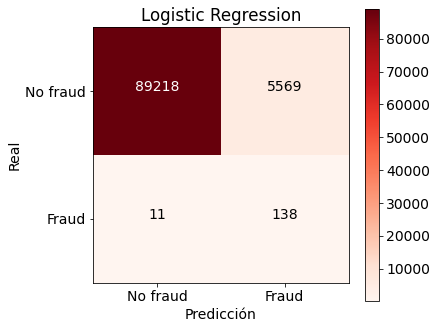

In [41]:
classifier = LogisticRegression()


start_time = timer()
classifier.fit(X_train_undersampled, y_train_undersampled)
y_pred_undersample = classifier.predict(X_test)
elapsed_time = timer() - start_time
print("Elapsed time:", timedelta(seconds=elapsed_time))

training_score = cross_val_score(classifier,X_train_undersampled, y_train_undersampled, cv=5)

print(classifier.__class__.__name__,"has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
print()

conf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Classification report")
print(classification_report(y_test,y_pred_undersample,target_names=['0', '1']))

print()

# Plot confusion matrix
class_names = ["No fraud","Fraud"]
plt.figure()
plot_confusion_matrix(conf_matrix
                      , classes=class_names
                      , title='Logistic Regression')
plt.show()



## SVM

Elapsed time: 0:00:01.121705
SVC has a training score of 93.0 % accuracy score

Classification report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     94787
           1       0.07      0.91      0.13       149

    accuracy                           0.98     94936
   macro avg       0.54      0.94      0.56     94936
weighted avg       1.00      0.98      0.99     94936



<Figure size 432x288 with 0 Axes>

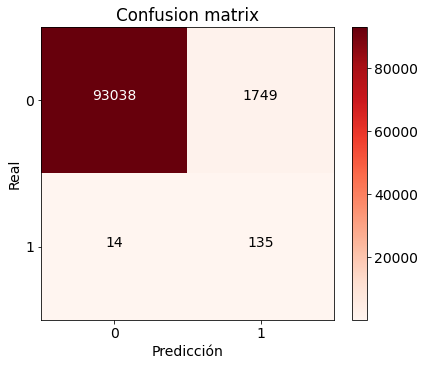

In [42]:
classifier = SVC()


start_time = timer()
classifier.fit(X_train_undersampled, y_train_undersampled)
y_pred_undersample = classifier.predict(X_test)
elapsed_time = timer() - start_time
print("Elapsed time:", timedelta(seconds=elapsed_time))

training_score = cross_val_score(classifier,X_train_undersampled, y_train_undersampled, cv=5)

print(classifier.__class__.__name__,"has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
print()

conf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Classification report")
print(classification_report(y_test,y_pred_undersample,target_names=['0', '1']))

# Plot confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(conf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## K Neighbors

Elapsed time: 0:00:03.500154
KNeighborsClassifier has a training score of 94.0 % accuracy score

Classification report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     94787
           1       0.04      0.91      0.08       149

    accuracy                           0.97     94936
   macro avg       0.52      0.94      0.53     94936
weighted avg       1.00      0.97      0.98     94936



<Figure size 432x288 with 0 Axes>

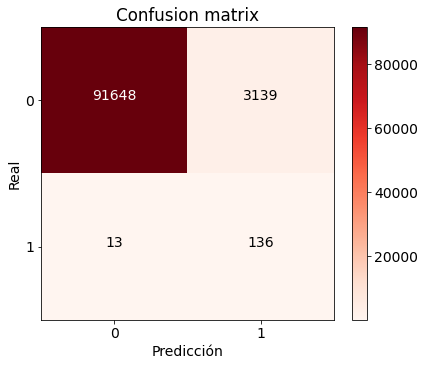

In [44]:
classifier = KNeighborsClassifier()


start_time = timer()
classifier.fit(X_train_undersampled, y_train_undersampled)
y_pred_undersample = classifier.predict(X_test)
elapsed_time = timer() - start_time
print("Elapsed time:", timedelta(seconds=elapsed_time))

training_score = cross_val_score(classifier,X_train_undersampled, y_train_undersampled, cv=5)

print(classifier.__class__.__name__,"has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
print()

conf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)


print("Classification report")
print(classification_report(y_test,y_pred_undersample,target_names=['0', '1']))

# Plot confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(conf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## Decision Tree

Elapsed time: 0:00:00.039803
DecisionTreeClassifier has a training score of 91.0 % accuracy score

Classification report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     94787
           1       0.01      0.91      0.03       149

    accuracy                           0.90     94936
   macro avg       0.51      0.91      0.49     94936
weighted avg       1.00      0.90      0.95     94936



<Figure size 432x288 with 0 Axes>

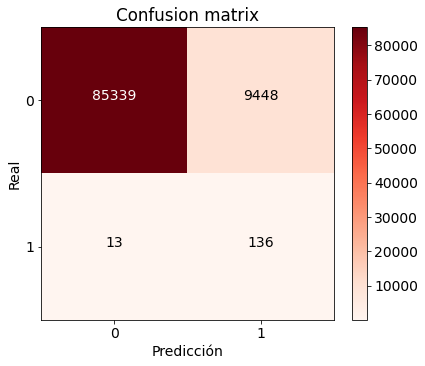

In [45]:
classifier = DecisionTreeClassifier()

start_time = timer()
classifier.fit(X_train_undersampled, y_train_undersampled)
y_pred_undersample = classifier.predict(X_test)
elapsed_time = timer() - start_time

training_score = cross_val_score(classifier,X_train_undersampled, y_train_undersampled, cv=5)
print("Elapsed time:", timedelta(seconds=elapsed_time))

print(classifier.__class__.__name__,"has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
print()

conf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Classification report")
print(classification_report(y_test,y_pred_undersample,target_names=['0', '1']))

# Plot confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(conf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## Tratando de predecir sin hacer resampling

Elapsed time: 0:00:02.875374
LogisticRegression has a training score of 100.0 % accuracy score
Classification report
              precision    recall  f1-score   support

   Non fraud       1.00      1.00      1.00     94787
       Fraud       0.87      0.64      0.74       149

    accuracy                           1.00     94936
   macro avg       0.94      0.82      0.87     94936
weighted avg       1.00      1.00      1.00     94936


Recall:  0.6375838926174496


<Figure size 432x288 with 0 Axes>

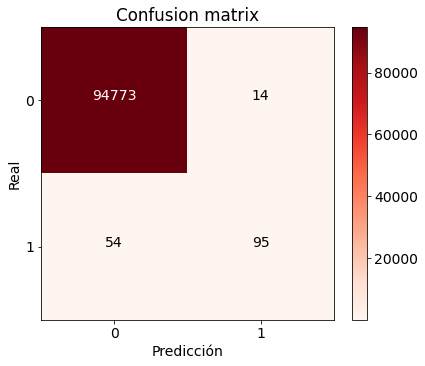

In [46]:
X_train_original = train_data.drop('Class', axis=1)
y_train_original = train_data['Class']

classifier = LogisticRegression(max_iter=120)

start_time = timer()
classifier.fit(X_train_original, y_train_original)
y_pred = classifier.predict(X_test)
elapsed_time = timer() - start_time

training_score = cross_val_score(classifier,X_train_original, y_train_original, cv=5)
print("Elapsed time:", timedelta(seconds=elapsed_time))

print(classifier.__class__.__name__,"has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

conf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Classification report")
print(classification_report(y_test,y_pred, target_names=['Non fraud', 'Fraud']))
print()

print("Recall: ", conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]))

# Plot confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(conf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()